In [1]:
from diff_weighted_fields import Grid1D, Field1D, PowerSpectrum, GaussianFieldGenerator1D, Zeldovich1D
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax
from jax import device_put
import jax_cosmo as jc
import jax_cosmo.background as bkgrd

jax.config.update("jax_enable_x64", True)

#grid setup
L = 4000
N = 2024
dk     = 10  #units of kf 
kmin   = 2  #units of kf
R_clip = 3  #units of cell size
kmax   =0.8 #units of kNyq

#define the field and gaussian generator
grid = Grid1D((N,), L, R_clip = R_clip, dk =dk, kmax = kmax , kmin =kmin)
mesh = Grid1D((N//2,), L, R_clip = R_clip, dk =dk, kmax = 0.6 , kmin =kmin)
k_ctrs = grid.k_ctrs
k_mesh = mesh.k_ctrs

def PK(k,theta):
    Omega_c, h = theta
    cosmo_jax = jc.Cosmology(Omega_c=Omega_c, Omega_b=0.05, h=h, sigma8 = 0.8, n_s=0.96,
                      Omega_k=0., w0=-1., wa=0.)
    pk = jc.power.linear_matter_power(cosmo_jax,k_ctrs)
    return jnp.interp(k, k_ctrs, pk)

Using clipping smoothing with R_clip = 3 cells (physical = 5.928853754940711); k_clip = 1.060e+00
kmin: 0.0031415926535897933
kmax: 1.2717167061731485
dk: 0.015707963267948967
Using clipping smoothing with R_clip = 3 cells (physical = 11.857707509881422); k_clip = 5.299e-01
kmin: 0.0031415926535897933
kmax: 0.4768937648149306
dk: 0.015707963267948967


In [2]:
#gaussian and zeldovich field generators
gen = GaussianFieldGenerator1D(grid, PK)
zel = Zeldovich1D(gen, mesh, scheme = 'cic')

#white noise used to generate the field
keys = split(PRNGKey(2),500)
noise = jnp.array([grid.generate_hermitian_noise(x) for x in keys])

In [3]:
Omega_c = 0.3
h = 0.7
cosmo = jc.Cosmology(Omega_c=Omega_c, Omega_b=0.05, h=h, sigma8 = 0.8, n_s=0.96,
                      Omega_k=0., w0=-1., wa=0.)
D = bkgrd.growth_factor(cosmo, jnp.atleast_1d(1))

Text(0, 0.5, '$\\delta$')

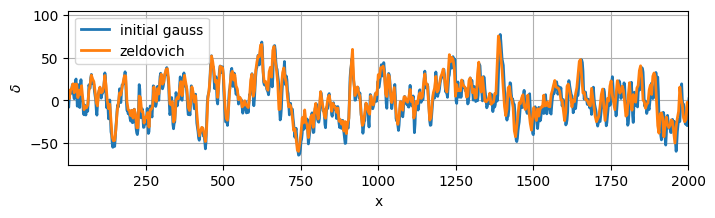

In [4]:
D = 0.001
gauss = gen.make_realization_from_noise((Omega_c,h),noise[0])
gauss.compute_ifft()

#zel are generated originally in fourier
zel = zel.make_realization(D,[Omega_c,h],noise[0])

plt.figure(figsize = (8,2))
plt.plot(gauss.grid.q, gauss.delta, lw =2, label = 'initial gauss')
plt.plot(zel.grid.q,zel.delta/D, lw = 2, label = 'zeldovich')
plt.xlim((1,2000))
#plt.ylim((-0.4,0.8))
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$\delta$')

In [5]:
def _plin_mark(D,Omega_c,h,R_smooth,C,noise):
    zel = Zeldovich1D(gen, mesh, scheme = 'cic')
    zel = zel.make_realization(D, (Omega_c, h), noise)
    zel.compute_fft()
    zel.ComputeBasis(R_smooth)
    f = zel.WeightedChild(C)
    return PowerSpectrum(f, f)

plin_mark = lambda D, Omega_c, h, R_smooth, C: jnp.mean(
    jax.vmap(_plin_mark, in_axes=(None, None, None, None, None, 0))(
        D, Omega_c, h, R_smooth, C, noise
    ),
    axis=0,
)

def _plin(Omega_c,h,noise):
    gauss = gen.make_realization_from_noise((Omega_c,h),noise)
    return PowerSpectrum(gauss, gauss)

plin = lambda Omega_c, h: jnp.mean(
    jax.vmap(_plin, in_axes=(None, None, 0))(
       Omega_c, h, noise
    ),
    axis=0,
)

plin_mark_jit = jax.jit(plin_mark)
plin_jit = jax.jit(plin)

#warmup
_ = plin_mark_jit(0.001, Omega_c, h, 10, jnp.array([1,0,0,0]))
_ = plin_jit(Omega_c, h)

In [17]:
%%timeit -n 1 -r 10
plin_mark_jit(0.001, Omega_c, h, 10, jnp.array([1,0,0,0]))

The slowest run took 14.25 times longer than the fastest. This could mean that an intermediate result is being cached.
563 μs ± 760 μs per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [18]:
D = 0.001
Omega_c = 0.3
h = 0.7
R_smooth = 20
C = jnp.array([1.,0,0,0])

In [37]:
dP_dOmegac = jax.jacfwd(plin_mark,argnums=(1))
dP_dh = jax.jacfwd(plin_mark,argnums=(2))

dP_dOmegac_jit = jax.jit(dP_dOmegac)
dP_dh_jit = jax.jit(dP_dh)
_ = dP_dOmegac_jit(D, Omega_c, h, R_smooth, C)
_ = dP_dh_jit(D, Omega_c, h, R_smooth, C)

In [43]:
%timeit -n 2 -r 10 dP_dOmegac_jit(0.001, Omega_c, h, 10, jnp.array([1,0,0,0]))

The slowest run took 1232.75 times longer than the fastest. This could mean that an intermediate result is being cached.
75.3 ms ± 149 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)
